In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx to Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx
Saving esami coorti 2016-2018 - 2020 02 21 per AI.xlsx to esami coorti 2016-2018 - 2020 02 21 per AI.xlsx
User uploaded file "Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx" with length 6481955 bytes
User uploaded file "esami coorti 2016-2018 - 2020 02 21 per AI.xlsx" with length 15391182 bytes


In [17]:
import pandas as pd
import numpy as np

#Read dataset
features =  pd.read_excel("Coorti 2016-2018 estrazione 2020 02 21 per AI.xlsx")
esami = pd.read_excel("esami coorti 2016-2018 - 2020 02 21 per AI.xlsx")

Siamo interessati al totale dei CFU ottenuti e la media dei voti ottenuti, inoltre abbiamo tenuto soltanto quelli del primo semestre

In [18]:
esami = esami.drop('Cod.Orientamento', axis=1)
esami = esami.drop('Cod.Indirizzo', axis=1)
esami = esami.drop('Cod.Materia', axis=1)
esami = esami.drop('Materia', axis=1)
index_name = esami[(esami['Giorno_esame'].dt.month > 2) & (esami['Giorno_esame'].dt.month < 11)].index
esami.drop(index_name, inplace = True)

Calcoliamo la somma dei CFU per ogni studente la mergiamo con i dati di ogni studente e i valori NaN dei CFU verranno rimpiazzati con 0

In [19]:
tot_cfu = esami.groupby('ID_Studente')['CFUsuperati'].sum()
features = features.merge(tot_cfu,how='outer', on='ID_Studente')
features['CFUsuperati'] = features['CFUsuperati'].fillna(0)

Calcoliamo la media di voti per ogni studente e la mergiamo con i dati di ogni studente e i valori NaN dei voti verranno rimpiazzati con 0

In [20]:
esami = esami.drop('CFUsuperati', axis=1)
esami = esami.dropna()
media_voti = esami.groupby('ID_Studente')['Voto_se_numerico'].mean()
features = features.merge(media_voti,how='outer', on='ID_Studente')
features['Voto_se_numerico'] = features['Voto_se_numerico'].fillna(0)

Rimpiazziamo i codici relativi a determinate feature con i nomi delle feature, così da poter utilizzare la funzione get_dummies() ed ottenere un one-hot-encoding

In [21]:
features["Diploma_scuola_superiore"] = features["Diploma_scuola_superiore"].map({1: "Classico", 2: "Scientifico", 3: "Linguistico", 4: "Magistrale", 5: "Artistico", 6: "Tecnico", 7: "Professionale", 8: "Altro_italiano", 9: "Estero", 99: "Non_disponibile"})
features["area_geografica_scuolasuperiore"] = features["area_geografica_scuolasuperiore"].map({1: "Emilia_romagna", 2: "Nord", 3: "Centro", 4: "Sud_isole", 5: "Estero", 99: "Non_disponibile"})
features["area_geografica_residenza"] = features["area_geografica_residenza"].map({1: "Emilia_romagna", 2: "Nord", 3: "Centro", 4: "Sud_isole", 5: "Estero", 99: "Non_disponibile"})
features["Ambito"] = features["Ambito"].map({1: "Economia", 2: "Farmacia", 3: "Giurisprudenza", 4: "Ingegneria", 5: "Lingue", 6: "Medicina", 7: "Veterinaria", 8: "Psicologia", 9: "Scienze", 10: "Scienze_agroalimanetari", 11: "Scienze_educazione_formazione", 12: "Scienze_motorie", 13: "Scienze_politiche", 14: "Scienze_statistiche", 15: "Sociologia", 16: "Studi_umanistici"})
features = pd.get_dummies(features)

In [22]:
from datetime import datetime, date

def getAge(dataNascita, coorte):
    ts = pd.to_datetime(str(dataNascita)) 
    born = ts.strftime('%d/%m/%Y')
    born = datetime.strptime(born, "%d/%m/%Y").date()
    date = "31/12/"+str(coorte)
    dataAttuale = datetime.strptime(date, "%d/%m/%Y").date()
    age = dataAttuale.year - born.year - ((dataAttuale.month, dataAttuale.day) < (born.month, born.day))
    return age

#add new column with NaN
features["Eta"] = np.nan

for ind in features.index:
    studente = features.loc[ind]
    dataNascita = studente["DataNascita"]
    coorte = studente["Coorte"]
    #fill the new column with age 
    features.at[ind,'Eta'] = getAge(dataNascita, coorte)


Qui l'ISEE di coloro che non l'hanno presentato, viene sostitito con la media degli ISEE oltre i $70000

In [23]:
rich =  features[features['Merito_ISEE'] > 70000]
rich = rich['Merito_ISEE']
mean_rich = rich.mean()
features = features[features['Classe_ISEE'] != 0]
features['Merito_ISEE'] = features['Merito_ISEE'].fillna(mean_rich)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Inoltre sono state droppate le colonne non utili ai fini dell'addestramento, ed infine eliminate le tuple contente almeno un NaN

In [24]:
mean_value = features['voto_scuola_superiore'].mean()
features['voto_scuola_superiore'] = features['voto_scuola_superiore'].fillna(mean_value)
features= features.drop('ID_Studente', axis = 1)
features= features.drop('Classe_ISEE', axis = 1)
features= features.drop('DataNascita', axis = 1)
features = features.drop('Coorte', axis = 1)
features = features.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##Bilanciamento 1

Abbiamo bilanciato il dataset con approccio downsampling pareggiando il numero di dropout e non droput

In [10]:
#Data preprocessing
dropout = pd.DataFrame()
noDropout = pd.DataFrame()

for ind in features.index:
    studente = pd.DataFrame(features.loc[[ind]])
    if features["Abbandoni"][ind] == 1:
        dropout = pd.concat([studente, dropout], ignore_index=True, axis = 0)
    else:
        noDropout = pd.concat([studente, noDropout], ignore_index=True, axis = 0)

#Bilanciamento dataset
final = pd.DataFrame()
for ind in dropout.index:
    studente_drop = pd.DataFrame(dropout.loc[[ind]])
    studente_noDrop = pd.DataFrame(noDropout.loc[[ind]])
    final = pd.concat([studente_drop, final], ignore_index=True, axis = 0)
    final = pd.concat([studente_noDrop, final], ignore_index=True, axis = 0)

print(len(final))
#Dividing the data into attributes and labels
X = final.drop('Abbandoni', axis=1)
y = final['Abbandoni']

8750


##Bilanciamento 2

In [25]:
#Dividing the data into attributes and labels
X = features.drop('Abbandoni', axis=1)
y = features['Abbandoni']

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

#Resampling data
rus = RandomUnderSampler(sampling_strategy = "majority", random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

X = X_res
y = y_res

Resampled dataset shape Counter({0: 4375, 1: 4375})


# Algorithm

Split the training testing set with a 20 % size and print the dimension of the data splitted
Split arrays or matrices into random train and test subsets.

In [26]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import metrics

X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((7000, 62), (1750, 62), (7000,), (1750,))

Build a model and fit it with training test

In [27]:
model = linear_model.LogisticRegression()
model.fit(X_train,Y_train)

LogisticRegression()

Predict a value in Y_pred using model defined previously

In [28]:
Y_pred = model.predict(X_test)

#Evaluating

In [29]:
print('Coefficients: ',model.coef_)
print('Intercept: ',model.intercept_)
print('Mean Squared Error :%.2f' % mean_squared_error(Y_test,Y_pred))
print('Coefficient of determination (R ^2): %.2f' % r2_score(Y_test,Y_pred))

Coefficients:  [[ 1.97454653e-03  2.30622096e-03  3.89144471e-06  5.53557543e-03
  -2.25799762e-03  8.99269277e-05  5.58832096e-03 -1.32315981e-03
  -8.24935516e-04 -7.68026992e-02 -5.10583675e-02  1.47431203e-04
   6.35065984e-04 -1.22625921e-03  2.03533074e-04  3.11197321e-05
   1.78479623e-03 -1.89372616e-03  1.28377425e-03 -4.32457482e-03
   4.97274699e-03  9.17162490e-05  3.97847904e-03  1.61119028e-04
  -1.89225537e-03  9.56977922e-04 -1.68212960e-03 -7.92249896e-04
   4.20855964e-03  9.43301712e-04  0.00000000e+00  3.30348668e-04
  -3.07605285e-03  9.46104745e-03 -9.02401948e-03  1.17687930e-03
  -5.32615265e-04  4.90205986e-04  2.07652314e-03 -2.56680812e-03
  -8.29769003e-04 -5.16866970e-04 -1.21054785e-04  1.22993981e-03
  -1.20017306e-04  9.76329620e-04 -2.16863288e-04  3.15712171e-05
   2.34909734e-04  2.42305891e-04  1.22362411e-03  1.24925003e-05
   1.10975117e-03 -4.72707963e-04  1.59886661e-04 -8.92399215e-05
  -9.12865659e-04  2.15238918e-04 -1.47394161e-04  6.24266830

Evaluating the algorithm

we compute the confusion matrix, but it can't operate with continuos value, we must convert in [0,1].we say that any value in Y_pred above (0.6,1) convert to 1 otherwise 0

In [30]:
print("Evaluating the Algorithm:\n")
cf_matrix = metrics.confusion_matrix(Y_test,Y_pred)
print(cf_matrix)
print(metrics.classification_report(Y_test,Y_pred))


print("true negative",cf_matrix[0,0])
print("false negative",cf_matrix[1,0])
print("true positive",cf_matrix[1,1])
print("false positive",cf_matrix[0,1])

print("\nEvaluating Prediction Accuracy:\n")
print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))

Evaluating the Algorithm:

[[726 157]
 [241 626]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       883
           1       0.80      0.72      0.76       867

    accuracy                           0.77      1750
   macro avg       0.78      0.77      0.77      1750
weighted avg       0.77      0.77      0.77      1750

true negative 726
false negative 241
true positive 626
false positive 157

Evaluating Prediction Accuracy:

Accuracy: 0.7725714285714286


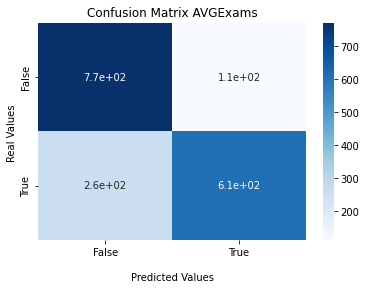

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix AVGExams');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Real Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()